* ## Carregar os pacotes

In [ ]:
import torch
import numpy as np
import pandas as pd
import unicodedata, re
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import (BertTokenizer, 
                          BertModel)
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline
torch.cuda.is_available()

#### Carregar e inicializar o modelo e o tokenizador usando modelo pré-treinado em português pela neuralmind.
#### O modelo consegue diferenciar o case, portanto o construtor especializado é inicializado com com padronização para miniscula falso.

In [2]:
model = BertModel.from_pretrained('neuralmind/bert-base-portuguese-cased')
tokenizer = BertTokenizer.from_pretrained(
    'neuralmind/bert-base-portuguese-cased', 
    do_lower_case=False)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Método para para processar texto, performando alguns ajustes no documento.

In [427]:
def preprocess(row):
    name = row["name"]
    brand = row["brand"]

    txt = unicodedata.normalize('NFD', str(name))
    name = ''.join([char for char in txt if not unicodedata.combining(char)])
    pattern = r'\s*' + re.escape(brand) + r'\b'
    name = name.lower()
    name = re.sub(r'\s*/?\s*REF\.\s*\w+', '', name, flags=re.IGNORECASE)
    name = re.sub(
        r'dimax|br|dimar|dinar|comfort|door|decor|santa|constru|bella|xcm|xmm|mm|cm|kg| m |xm|\s*x\s*',
        '', name, flags=re.IGNORECASE)
    name = re.sub(r'[0-9.,/-]', '', name)
    name = re.sub(pattern, '', name, flags=re.IGNORECASE).strip()

    #cleaned_name_tokens = [word for word in name if word not in stop_words]

    row["name"] = name

    return row

root_path = "../../data/"

df = pd.read_csv(root_path+"df.csv")
df = df[["id", "name", "brand", "price"]]
df.reset_index(drop=True, inplace=True)
df.drop_duplicates(inplace=True)
df_clean = df.copy()
df = df.apply(preprocess, axis=1)
display(df.head())
df.shape

,id,name,brand,price
0,985540,telha ecologica classica fit vermelho,ONDULINE,85.9
1,991239,pneu aro com lonas leve,COLSON,32.9
2,996014,caia para massa de plastico litros reforcada,DIMAX BR,24.9
3,996109,esquadro em aco polegadas com cabo de plastico preto,DIMAX BR,18.9
4,996108,esquadro em aco polegadas com cabo de plastico preto,DIMAX BR,17.9


(10188, 4)

In [241]:
df.shape, df_clean.shape

((10188, 4), (10188, 4))

In [428]:
docs = df["name"]

In [6]:
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(29794, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [7]:
device

device(type='cpu')

#### Aqui, cria-se um dicionário com dois elementos. Os ids e as máscaras de atenção que serão gerados.
#### Da linha 2 à 10, cria-se os tokens usando o tokenizador inicializado com comprimento máximo dos tokens, truncamento e o preenchimento dos indices.
#### Nas 9 e 10, adiciona-se os ids e as máscaras como valores para as chaves no dicionário.
#### As linhas 12 e 13 servem para concatenar os elementos, criando assim para cada chave, uma lista única.

In [338]:
tokens = {"input_ids": [], "attention_mask": []}
for sentence in docs:
    new_token = tokenizer.encode_plus(sentence, 
                                      max_length=12,
                                      truncation=True, 
                                      padding='max_length',
                                      return_tensors='pt')
    
    tokens['input_ids'].append(new_token['input_ids'][0])
    tokens['attention_mask'].append(new_token['attention_mask'][0])

tokens['input_ids'] = torch.stack(tokens['input_ids'])
tokens['attention_mask'] = torch.stack(tokens['attention_mask'])
#tokens = {key: value.to(device) for key, value in tokens.items()}

In [339]:
with torch.no_grad():
    outputs = model(**tokens)
outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output'])

In [340]:
embeddings = outputs.last_hidden_state
mask = (tokens['attention_mask']
                  .unsqueeze(-1)
                  .expand(embeddings.size()))

In [341]:
mask.shape

torch.Size([10188, 12, 768])

In [435]:
mask_embeddings = embeddings * mask
sum = torch.sum(mask_embeddings, 1)
mean = sum / torch.clamp(mask.sum(1), min=1e-9)
embeddings_mean = pd.DataFrame(mean.numpy())

In [313]:
print(cosine_similarity(mean))
# cs = cosine_similarity(mean_pooled.cpu().numpy())
# X = 1 - ((cs + 1) / 2)
# X.shape

[[0.99999976 0.6934425  0.68843436 0.6776743  0.6865008 ]
 [0.6934425  1.         0.58205485 0.65254295 0.6538353 ]
 [0.68843436 0.58205485 0.99999994 0.712289   0.7144328 ]
 [0.6776743  0.65254295 0.712289   0.99999976 0.98726976]
 [0.6865008  0.6538353  0.7144328  0.98726976 0.99999964]]


In [343]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [436]:
db = DBSCAN(eps=0.1, min_samples=3, metric="cosine").fit(embeddings_mean)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [437]:
df["clusters"] = labels
df_clean["clusters"] = labels
embeddings_mean["clusters"] = labels

In [438]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print(f"clusters number: {n_clusters_}", end="\n" f"noise number: {n_noise_}")

clusters number: 608
noise number: 1948

In [362]:
df_clean[df_clean.clusters == 6]

,id,name,brand,price,clusters
66,979293,"Eletrodo em Aço 7018 3,25mm - Ref. 7457701832 - VONDER",VONDER,31.9,6
68,979294,"Eletrodo em Aço 7018 4,0mm - Ref. 7457701840 - VONDER",VONDER,32.9,6
70,979292,"Eletrodo em Aço 7018 2,5mm - Ref. 7457701825 - VONDER",VONDER,35.9,6
10154,949801,"Eletrodo em Aço 6013 2,50mm - Ref. 7457601325 - VONDER",VONDER,24.9,6
10155,949818,"Eletrodo em Aço 6013 3,25mm - Ref. 7457601332 - VONDER",VONDER,23.9,6


In [439]:
non_noise = df_clean[df_clean['clusters'] != -1]
non_noise_embed = embeddings_mean[embeddings_mean['clusters'] != -1]

Clusters estimated: 608
Noise s points: 1948
Silhouette Score: 0.3224


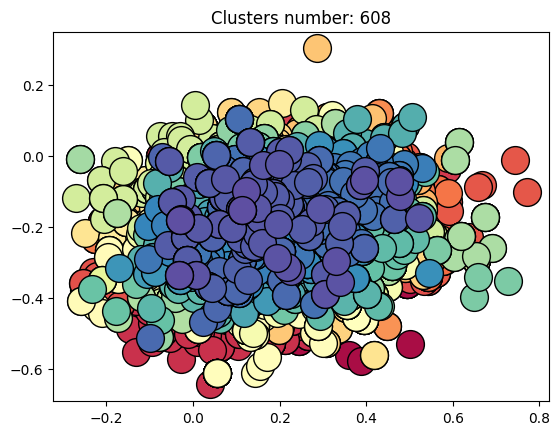

In [445]:
print('Clusters estimated: %d' % n_clusters_)
print('Noise s points: %d' % n_noise_)
print("Silhouette Score: %0.4f" % metrics.silhouette_score(
    non_noise_embed.iloc[:,:-1], non_noise_embed.clusters)
)

unique_labels = set(non_noise.clusters)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
#X_df = X_df * 10
for cluster, color in zip(unique_labels, colors):
    if cluster == -1:
        color = [0, 0, 0, 1]

    class_member_mask = (labels == cluster)
    mp = mean[class_member_mask & core_samples_mask]
    plt.plot(
        mp[:, 0], mp[:, 1], 'o',
        markerfacecolor=tuple(color),
        markeredgecolor='k', 
        markersize=20)

plt.title('Clusters number: %d' % n_clusters_)
plt.show()

In [353]:
from sklearn.manifold import TSNE

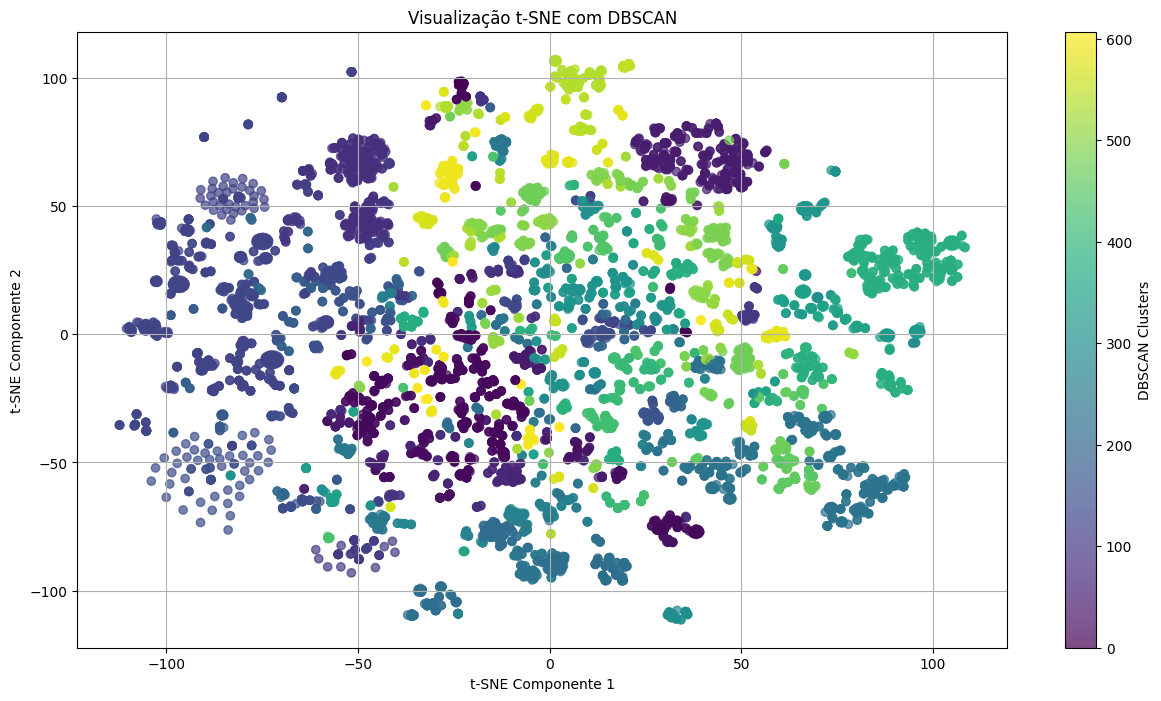

In [447]:
perplexity_value = 30
if perplexity_value >= non_noise_embed.shape[0]:
    perplexity_value = non_noise_embed.shape[0] - 2
tsne = TSNE(
    n_components=2,
    random_state=42,
    perplexity=perplexity_value)
X_embedded = tsne.fit_transform(
    non_noise_embed.iloc[:, :-1])

plt.figure(figsize=(15, 8))
scatter = plt.scatter(
    X_embedded[:, 0],
    X_embedded[:, 1],
    c=non_noise_embed.clusters,
    alpha=0.7,
    marker='o')

plt.title('Visualização t-SNE com DBSCAN')
plt.xlabel('t-SNE Componente 1')
plt.ylabel('t-SNE Componente 2')
plt.colorbar(scatter, label='DBSCAN Clusters')
plt.grid()
plt.show()

In [458]:
cluster_stats = non_noise.groupby('clusters').agg(
    min=('price', 'min'),
    max=('price', 'max'),
    mean=('price', 'mean'),
    std=('price', 'std'),
)
cluster_stats = cluster_stats.reset_index()

In [459]:
cluster_stats

,clusters,min,max,mean,std
0,0,58.9,109.9,89.471429,15.956787
1,1,15.9,26.9,21.733333,4.708149
2,2,9.9,260.0,116.903571,75.069994
3,3,29.9,148.9,85.515000,43.391178
4,4,899.9,900.0,899.950000,0.057735
...,...,...,...,...,...
603,603,28.9,28.9,28.900000,0.000000
604,604,89.9,89.9,89.900000,0.000000
605,605,25.9,149.9,95.066667,40.400083
606,606,0.0,24.9,16.266667,14.096217


In [461]:
cluster_stats=cluster_stats.iloc[:10]

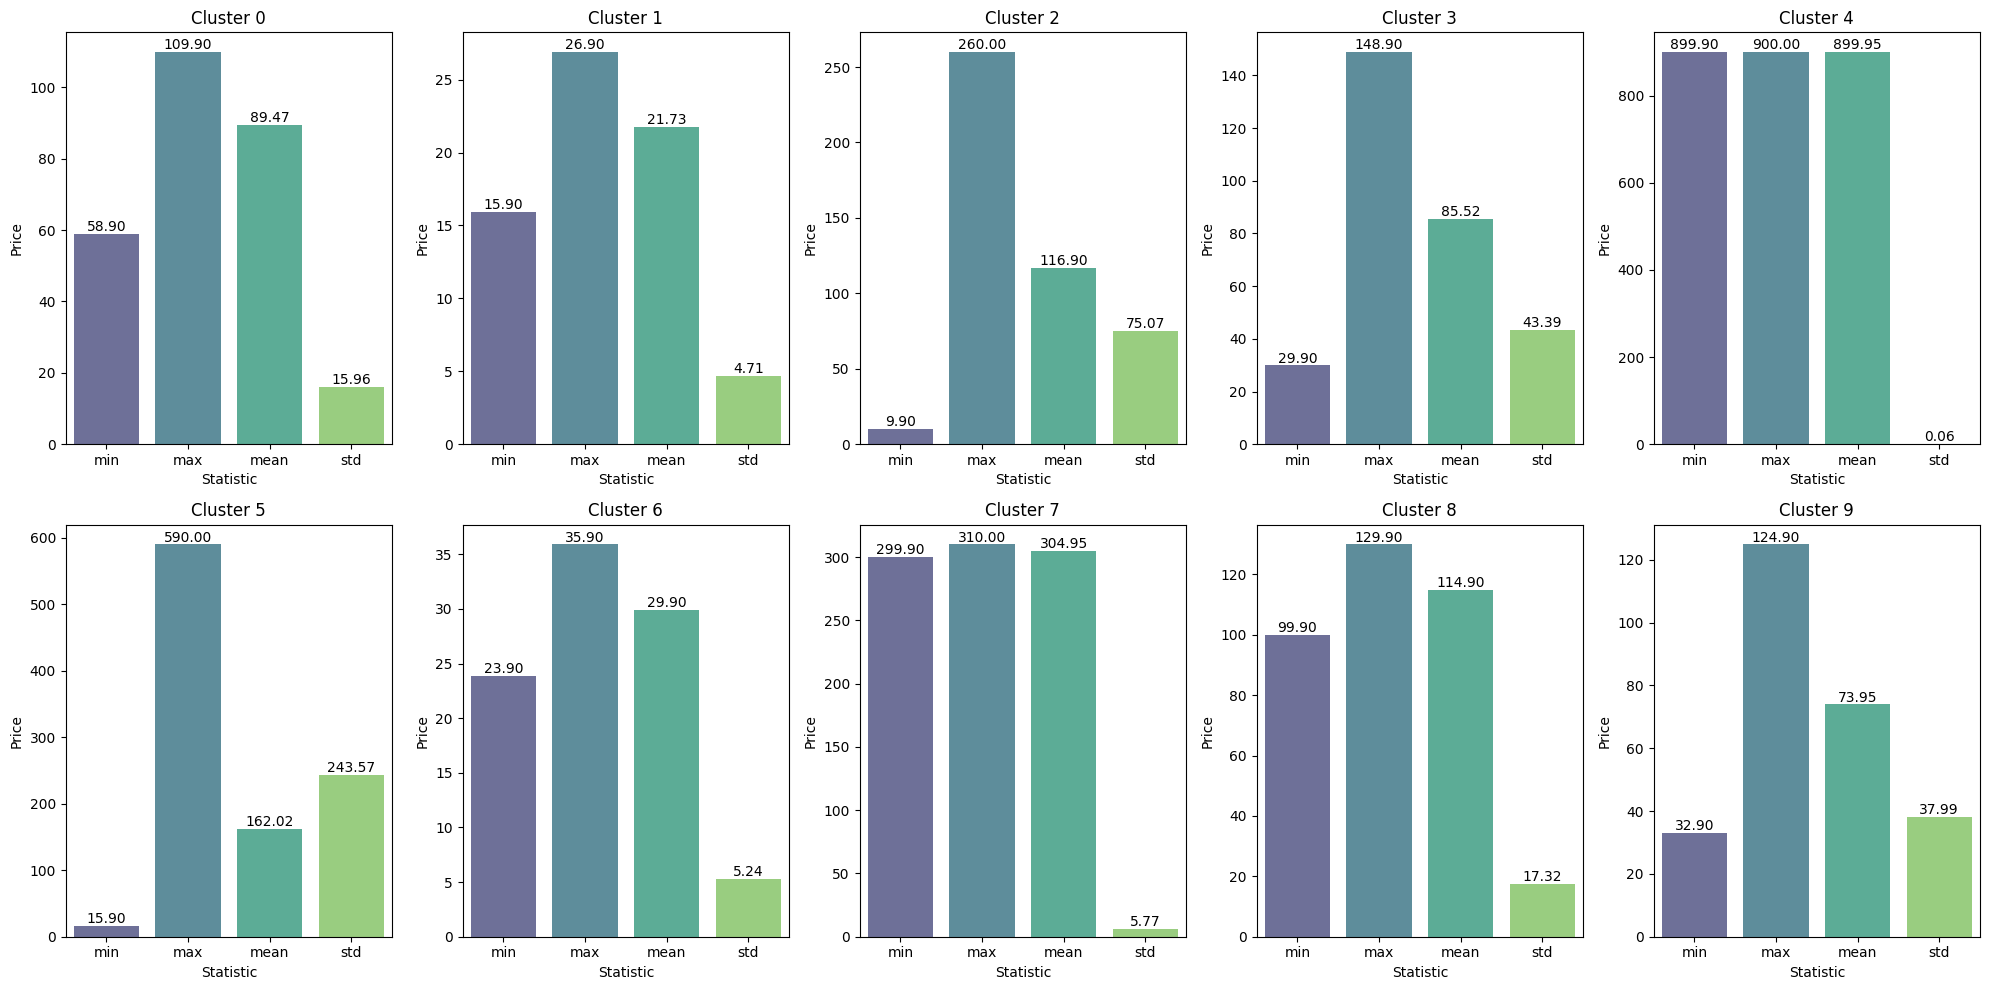

In [462]:
num_clusters = len(cluster_stats)
n_rows = 2
n_cols = 5

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < num_clusters:
        plot_data = cluster_stats.iloc[[i]].melt(
            id_vars='clusters',
            var_name='Statistic',
            value_name='Price')

        sns.barplot(
            x='Statistic', y='Price', hue = 'Statistic',
            legend=False, data=plot_data, ax=ax,
            palette='viridis', alpha=0.8)
        ax.set_title(f'Cluster {plot_data["clusters"].values[0]}')
        for p in ax.patches:
            ax.annotate(f'{p.get_height():.2f}',
                        (p.get_x() + p.get_width() / 2.,
                         p.get_height()),
                        ha='center', va='center',
                        fontsize=10, color='black',
                        xytext=(0, 5),
                        textcoords='offset points')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()